# Imports

In [1]:
import datetime
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt

# Signal configureations

In [7]:
def generate_signal_configs_list():
    device = 'he00001'
    begin_time = datetime.datetime(2018, 9, 16, 6, 0, 0)
    date_diff = datetime.timedelta(days = 1)
    hours_diff = datetime.timedelta(hours = 13)
    #hours_diff = datetime.timedelta(hours = 1)
    local_to_utc_offset = datetime.timedelta(hours = -3)

    return [{'device': device,
            'local_begin_datetime': begin_time + i*date_diff,
            'local_end_datetime': begin_time + i*date_diff + hours_diff,
            'utc_begin_datetime': begin_time + i*date_diff + local_to_utc_offset,
            'utc_end_datetime': begin_time + i*date_diff + hours_diff + local_to_utc_offset,
            'utc_time_begin': pd.Timestamp(begin_time + i*date_diff + local_to_utc_offset).value//10**9,
            'utc_time_end': pd.Timestamp(begin_time + i*date_diff + hours_diff + local_to_utc_offset).value // 10**9}
            for i in range(6)]

signal_configs_list = generate_signal_configs_list()

# Connection configurations

In [5]:
def connection_configurations():
    return {
    'host': 'vnmysql.c4a62i7b81an.us-east-2.rds.amazonaws.com',
    'user': 'vndbroot',
    'password': 'AkuoKfo321!',
    'db': 'vndb',
    'charset': 'utf8mb4',
    'cursorclass': pymysql.cursors.DictCursor
    }
connection_config = connection_configurations()


# Signal-independent configurations

In [4]:
def load_parameters():
    '''Signal-independent parameters'''
    return {
        'time_step': 1.0,
        'gap_duration_thresh': 5.0
    }

# Import signal

In [9]:
def signal_download(connection_config, signal_config):
    connection = pymysql.connect(host=connection_config['host'],
                                 user=connection_config['user'],
                                 password=connection_config['password'],
                                 db=connection_config['db'],
                                 charset=connection_config['charset'],
                                 cursorclass=connection_config['cursorclass']
                                 )
    try:
        with connection.cursor() as cursor:
            sql = 'SELECT event_timestamp, bmp_alt, gps_alt' \
                  ' FROM hawkeye_rawdata' \
                  ' WHERE event_timestamp > "{0}"' \
                  ' AND event_timestamp < "{1}"'\
                  ' AND device_sn = "{2}"'.format(signal_config['local_begin_datetime'],
                                                  signal_config['local_end_datetime'],
                                                  signal_config['device'])

            cursor.execute(sql)
            raw_data_array = cursor.fetchall()

    finally:
        connection.close()
    return raw_data_array

raw_data_array = signal_download(connection_config, signal_configs_list[1])


# Formatting signals

In [ ]:
def format_raw_data(raw_data_array):
    '''
    Author: Ehud Hahamy
    Date: 2018-07-29
    Synopsis: format raw data for numpy use
    Input:
     raw_data_array: 2-by-N list, one column for timestamps, the other of time-series values [list of dicts][timestamps, float]
    Output:
     ts_values_arr: array of time series values [1D numpy array][float]
     t_sec_arr: array of numerical time values with respect to the first recorded timestamp [1D numpy array][float]
     padded_timestamp_range: a gap-free timestamps array ranging from first to last timestamps
        in raw_data_array [1D numpy array][np.datetime64]
    '''

    frame = pd.DataFrame(raw_data_array)
    frame['gps_alt'].astype(float)
    t_sec_arr = frame['event_timestamp'].values
    t_sec_arr = (t_sec_arr - t_sec_arr[0])/np.timedelta64(1, 's')
    padded_timestamp_range = pd.date_range(start=raw_data_array[0]['event_timestamp'],
                                           end=raw_data_array[-1]['event_timestamp'],
                                           freq='1s').values

    return {
        'frame': frame,
        't_sec_arr': t_sec_arr,
        'padded_timestamp_range': padded_timestamp_range
    }
formatted_data_out = format_raw_data(raw_data_array)

# Convert signals to numpy

In [12]:
formatted_data_out = format_raw_data(raw_data_array)
frame = formatted_data_out['frame']

bmp_alt = frame['bmp_alt'].values
gps_alt_ser = frame['gps_alt'].astype(float)
gps_alt = gps_alt_ser.values

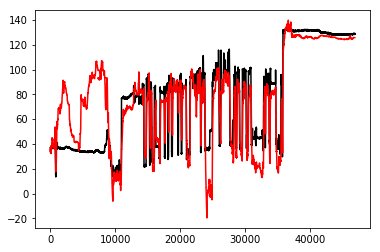

In [16]:
plt.figure(1)
plt.plot(bmp_alt,'k',label='bmp' )
plt.plot(gps_alt,'r',label = 'gps')

# Manually mark a list of intervals

In [17]:
interval_boundaries_mat = np.matrix([[13400,14400],
                           [14401,15000],
                           [15401,15800],
                           [15801,16400],
                           [16801,17700],
                           [17701,18200],
                           [18201,18800]
                           ])

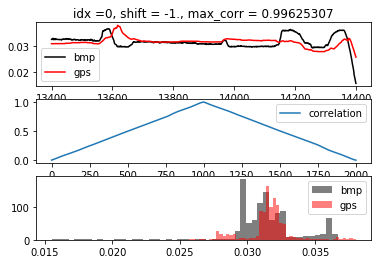

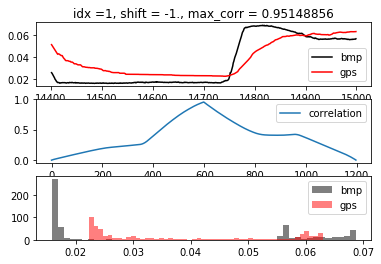

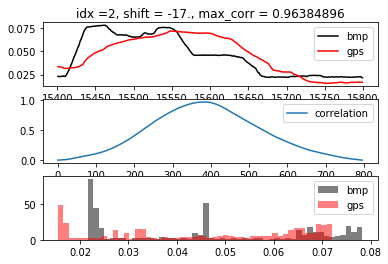

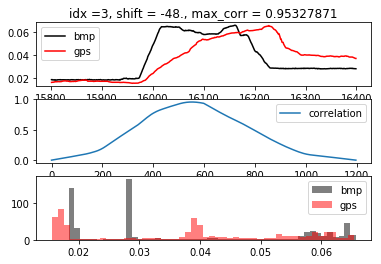

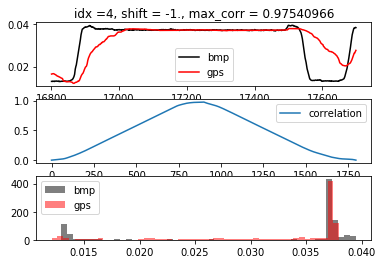

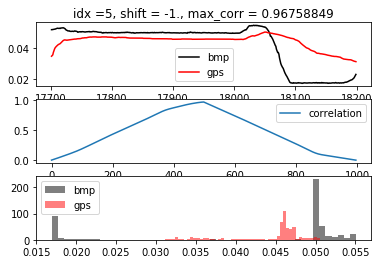

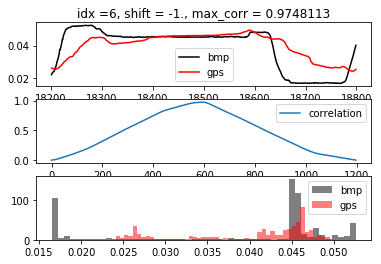

In [20]:
# Plot signals segments, correlation, histograms
shifts_list = np.zeros(interval_boundaries_mat.shape[0])
max_corr_list = np.zeros(interval_boundaries_mat.shape[0])
for k in np.arange(interval_boundaries_mat.shape[0]):
    interval = np.arange(interval_boundaries_mat[k,0],interval_boundaries_mat[k,1])
    bmp_seg = bmp_alt[interval]/np.linalg.norm(bmp_alt[interval])
    gps_seg = gps_alt[interval]/np.linalg.norm(gps_alt[interval])
    segs_corr = np.correlate(bmp_seg,gps_seg,'full')
    shifts_list[k]= np.argmax(segs_corr)-len(interval)
    max_corr_list[k] = np.max(segs_corr)

    fig = plt.figure(k)


    ax1 = fig.add_subplot(311)
    plt.title("idx =" + np.array2string(k) +", shift = " + np.array2string(shifts_list[k]) + ", max_corr = " + np.array2string(max_corr_list[k]))
    plt.plot(interval,bmp_seg, 'k', label = 'bmp')
    plt.plot(interval,gps_seg, 'r', label = 'gps')
    ax1.legend()

    ax2 = fig.add_subplot(312)
    plt.plot(segs_corr, label = 'correlation')
    ax2.legend()

    ax3 = fig.add_subplot(313)
    plt.hist(bmp_seg, 50, facecolor = 'k', alpha = 0.5, label = 'bmp')
    plt.hist(gps_seg, 50, facecolor = 'r', alpha = 0.5, label = 'gps')
    plt.grid = True
    ax3.legend()


In [21]:
print(shifts_list)

[ -1.  -1. -17. -48.  -1.  -1.  -1.]


# Manually select signal for demo and display it


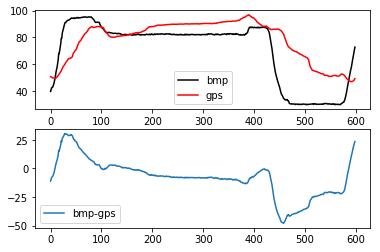

In [24]:
sig_id = 6
interval = np.arange(interval_boundaries_mat[sig_id,0],interval_boundaries_mat[sig_id,1])
bmp_seg = bmp_alt[interval]
gps_seg = gps_alt[interval]

fig = plt.figure(1)
ax1 = fig.add_subplot(211)
plt.plot(bmp_seg, 'k', label = 'bmp')
plt.plot(gps_seg, 'r', label = 'gps')
plt.legend()

ax2 = fig.add_subplot(212)
plt.plot(bmp_seg-gps_seg, label = 'bmp-gps')
plt.legend()
plt.show()


# Apply parameters estimation techniques to signals and difference signals

(array([ 2.,  3.,  5.,  1.,  1.,  2.,  0.,  1.,  2.,  1.,  2.,  1.,  2.,
         5.,  5.,  9., 13.,  5.,  5.,  9., 34., 32., 16.,  6.,  6.,  9.,
        12.,  5.,  2.,  4.]),
 array([-13.3875, -13.1325, -12.8775, -12.6225, -12.3675, -12.1125,
        -11.8575, -11.6025, -11.3475, -11.0925, -10.8375, -10.5825,
        -10.3275, -10.0725,  -9.8175,  -9.5625,  -9.3075,  -9.0525,
         -8.7975,  -8.5425,  -8.2875,  -8.0325,  -7.7775,  -7.5225,
         -7.2675,  -7.0125,  -6.7575,  -6.5025,  -6.2475,  -5.9925,
         -5.7375]),
 <a list of 30 Patch objects>)

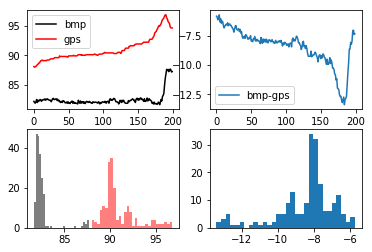

In [27]:
sub_interval = np.arange(200,400)
bmp_subseg = bmp_seg[sub_interval]
gps_subseg = gps_seg[sub_interval]
subsegs_diff = bmp_subseg-gps_subseg

fig = plt.figure(1)
ax1 = fig.add_subplot(221)
plt.plot(bmp_subseg, 'k', label = 'bmp')
plt.plot(gps_subseg, 'r', label = 'gps')
plt.legend()

ax2 = fig.add_subplot(222)
plt.plot(subsegs_diff, label = 'bmp-gps')
plt.legend()

ax3 = fig.add_subplot(223)
plt.hist(bmp_subseg, 30, facecolor = 'k', alpha = 0.5, label = 'bmp')
plt.hist(gps_subseg, 30, facecolor = 'r', alpha = 0.5, label = 'gps')

ax4 = fig.add_subplot(224)
plt.hist(subsegs_diff,30)


Select signal to get variance estimate for GPS, barometer

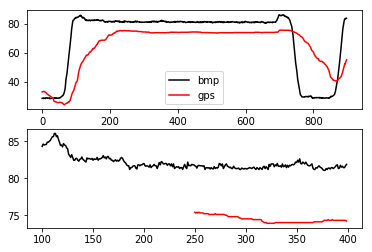

In [28]:
var_est_sig_id = 4
interval = np.arange(interval_boundaries_mat[var_est_sig_id,0],interval_boundaries_mat[var_est_sig_id,1])
bmp_var_est_seg = bmp_alt[interval]
gps_var_est_seg = gps_alt[interval]

fig = plt.figure(1)
ax1 = fig.add_subplot(211)
plt.plot(bmp_var_est_seg, 'k', label = 'bmp')
plt.plot(gps_var_est_seg, 'r', label = 'gps')
plt.legend()
bmp_var_est_subseg = bmp_var_est_seg[100:400]
gps_var_est_subseg = gps_var_est_seg[250:400]


ax2 = fig.add_subplot(212)
plt.plot(np.arange(100,400), bmp_var_est_subseg, 'k', label = 'bmp')
plt.plot(np.arange(250,400), gps_var_est_subseg, 'r', label = 'gps')
